## Perbandingan APBD Kabupaten/Kota Se-Jawa Timur

<p style="text-align: justify;">
APBD merupakan instrumen penting bagi Pemerintah Daerah dalam menyelenggarakan pelayanan dan meningkatkan kesejahteraan masyarakat. Oleh karena itu, memahami gambaran kinerja fiskal Kabupaten/Kota penting dilakukan untuk mengidentifikasi kemampuan tiap daerah menjalankan kewenangannya.  <br>
Notebook ini menggunakan data dengan periode 4 tahun, yakni dari tahun anggaran 2021 hingga 2024, dengan cakupan seluruh kabupaten/kota di Jawa Timur, sebanyak 38 daerah.<br>
Pemetaan ini terbatas pada beberapa aspek antara lain: <br>
1. Clustering APBD; <br>
2. Pemetaan kapasitas fiskal Kabupaten/Kota di Jawa Timur; <br>
3. Pertumbuhan APBD; <br>
4. Perhitungan Rasio PAD terhadap PDRB; <br>
5. Pemetaan Belanja Pegawai, khususnya dalam konteks penerapan Pasal 147 ayat (1) UU No. 1 Tahun 2022 tentang HKPD. <br>
Analisa sederhana ini disusun menggunakan Python sebagai alat analisis dan penyajian data. <br>

Sumber data APBD diperoleh dari [Portal SIKD Kementrian Keuangan](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38)<br>
Sumber data PDRB diperoleh dari [Portal BPS](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38)
</p>

### A. Persiapan Data
<p style="text-align: justify;">
Langkah pertama dalam penggunaan Python sebagai alat bantu adalah setup awal dan install modul/library yang dibutuhkan dalam analisa. Untuk menjaga konsistensi antar file, kita cantumkan nama daerah dan kode rekening masing-masing ke dalam sebuah array lalu menetapkan root directory (folder sumber) sebagai lokasi penyimpanan data.
</p>

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import geopandas as gpd

NAMA_DAERAH = [
    "Bangkalan", "Banyuwangi", "Batu", "Blitar", "Bojonegoro", "Bondowoso",
    "Gresik", "Jember", "Jombang", "Kediri", "Kota_Blitar", "Kota_Kediri",
    "Kota_Madiun", "Kota_Malang", "Kota_Mojokerto", "Kota_Pasuruan", 
    "Kota_Probolinggo", "Lamongan", "Lumajang", "Madiun", "Magetan", "Malang", 
    "Mojokerto", "Nganjuk", "Ngawi", "Pacitan", "Pamekasan", "Pasuruan", 
    "Ponorogo", "Probolinggo", "Sampang", "Sidoarjo", "Situbondo", "Sumenep", 
    "Surabaya", "Trenggalek", "Tuban", "Tulungagung"
]

REKENING = [
    "Pendapatan Daerah", "PAD", "Pajak Daerah", "Retribusi Daerah", 
    "Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan", "Lain-Lain PAD yang Sah", 
    "TKDD", "Pendapatan Transfer Pemerintah Pusat", "Pendapatan Lainnya", 
    "Belanja Daerah", "Belanja Operasi", "Belanja Pegawai", "Belanja Modal", 
    "Belanja Tidak Terduga", "Pembiayaan Daerah", 
    "Penerimaan Pembiayaan Daerah", "Pengeluaran Pembiayaan Daerah"
]

ROOT_DIR = Path(r'E:\Project\GH\APBDKabJatim\data\apbd')

Data APBD yang didapat dari [Portal SIKD Kemenkeu](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38) merupakan himpunan data berformat `.CSV`dengan pola penamaan `kabupaten/kota.csv`. File APBD ini tersimpan dalam direktori 'data' sebagai folder utama penyimpanan. <br>
Pada direktori utama ini kemudian tersimpan beberapa subfolder untuk menyimpan data APBD dengan penamaan sesuai tahun anggaran. <br>
Langkah selanjutnya adalah kita satukan seluruh data APBD ini (tersebar dalam 4 sub folder sesuai tahun anggaran) menjadi satu dataframe lalu dilanjutkan dengan cleaning data. 


In [64]:
def read_csv_files(root_dir):
    data = []
    for folder_tahun in root_dir.iterdir():
        if folder_tahun.is_dir():
            for file in folder_tahun.glob('*.csv'):
                try:
                    df = pd.read_csv(file)
                    df['Tahun'] = folder_tahun.name
                    df['Daerah'] = file.stem
                    data.append(df)
                except Exception as e:
                    print(f"Error membuka {file.name}: {str(e)}")
    
    if not data:
        raise ValueError("File CSV tidak ditemukan atau tidak dapat terbaca.")
    
    return pd.concat(data, ignore_index=True)

def clean_data(df):
    def convert_to_float(value):
        if isinstance(value, str):
            value = value.replace('M', '').strip()
            if '.' in value and ',' in value:
                value = value.replace('.', '').replace(',', '.')
            elif ',' in value:
                value = value.replace(',', '.')
            value = re.sub(r'[^\d.]', '', value)
        return float(value) if value else 0.0

    for col in ['anggaran', 'realisasi', 'persentase']:
        df[col] = df[col].apply(convert_to_float)
    return df

def match_category(category, valid_categories):
    return next((vc for vc in valid_categories if category.lower() in vc.lower()), None)

Setelah seluruh data disatukan dalam satu dataframe, selanjutnya kita cek apakah dataframe yang telah terbentuk mengakomodasi seluruh data APBD yang tersedia.

In [82]:
def process_budget_data(root_dir, selected_categories=None, target_year=2023):
    df = read_csv_files(root_dir)
    df = clean_data(df)
    df = df.drop_duplicates()

    # parameter target_year untuk menyaring data
    df = df[df['Tahun'].astype(int) == target_year]

    df = df.groupby(['akun', 'Daerah'])['anggaran'].sum().reset_index()
    df_pivot = df.pivot(index='Daerah', columns='akun', values='anggaran')
    
    for region in NAMA_DAERAH:
        if region not in df_pivot.index:
            df_pivot.loc[region] = 0
    
    df_pivot = df_pivot.loc[NAMA_DAERAH].fillna(0)
    
    if selected_categories:
        available_categories = df_pivot.columns.tolist()
                
        matched_categories = []
        for cat in selected_categories:
            matched = match_category(cat, available_categories)
            if matched:
                matched_categories.append(matched)
            else:
                print(f"Peringatan: Kategori '{cat}' tidak ditemukan.")
        
        if not matched_categories:
            print("Tidak ada kategori yang sesuai.")
        else:
            df_pivot = df_pivot[matched_categories]
                
    return df_pivot

def match_category(category, valid_categories):
    lowercase_category = category.lower()
    for valid_cat in valid_categories:
        if lowercase_category in valid_cat.lower():
            return valid_cat
    return None

kategori_anggaran = [
    "Pendapatan Daerah",
    "Belanja Daerah",
    "Pembiayaan Daerah"
]

# Ganti tahun anggaran di sini
tahun_anggaran = 2024
result_df = process_budget_data(ROOT_DIR, kategori_anggaran, target_year=tahun_anggaran)
print(result_df)

akun              Pendapatan Daerah  Belanja Daerah  Pembiayaan Daerah
Daerah                                                                
Bangkalan                   2402.58         2502.06               0.00
Banyuwangi                  3239.71         3429.71               0.00
Batu                        1034.32         1231.96               0.00
Blitar                      2539.66         2729.02             189.35
Bojonegoro                  5435.62         8235.03            2799.41
Bondowoso                   1984.27         2169.74               0.00
Gresik                      3915.51         3887.41              28.10
Jember                      4211.89         4366.08             154.19
Jombang                     2838.00         3076.00             238.00
Kediri                      3059.74         3486.92               0.00
Kota_Blitar                  911.13         1027.24               0.00
Kota_Kediri                 1424.24         1795.30               0.00
Kota_M

### B. Visualisasi Data
<p style="text-align: justify;">
Untuk lebih memberikan gambaran dataframe, kita visualisasikan data APBD antar daerah untuk tahun anggaran 2024
</p>

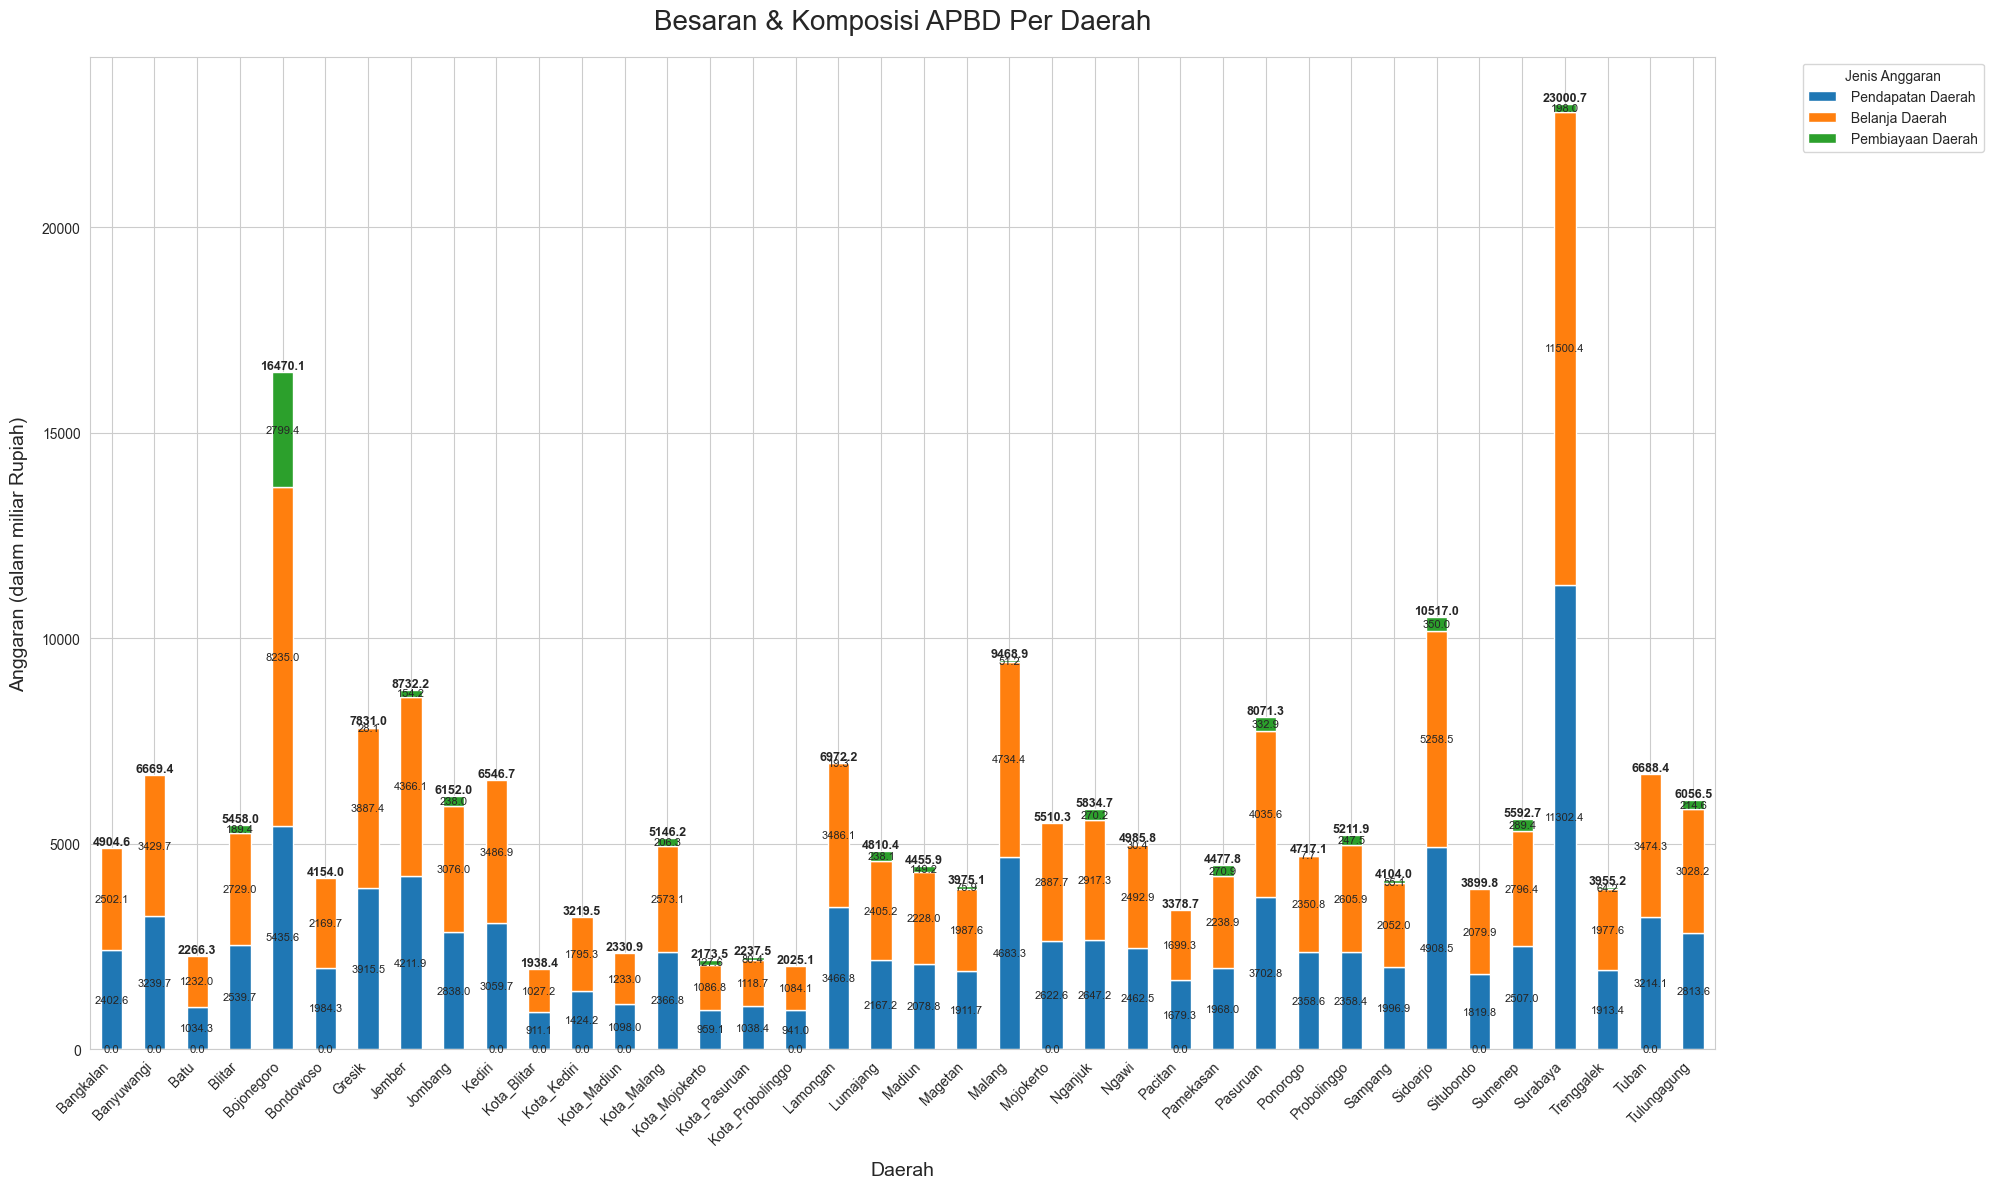

In [66]:
def visualize_budget_data(df, title='Besaran & Komposisi APBD Per Daerah', figsize=(20, 12)):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=figsize)
    df.plot(kind='bar', stacked=True, ax=ax)
    plt.title(title, fontsize=20, pad=20)
    plt.xlabel('Daerah', fontsize=14, labelpad=10)
    plt.ylabel('Anggaran (dalam miliar Rupiah)', fontsize=14, labelpad=10)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title='Jenis Anggaran', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', label_type='center', fontsize=8)

    for i, total in enumerate(df.sum(axis=1)):
        ax.text(i, total, f'{total:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

visualize_budget_data(result_df)

### C. Clustering APBD
<p style="text-align: justify;">
Clustering menggunakan K-Means berdasarkan anggaran.
</p>

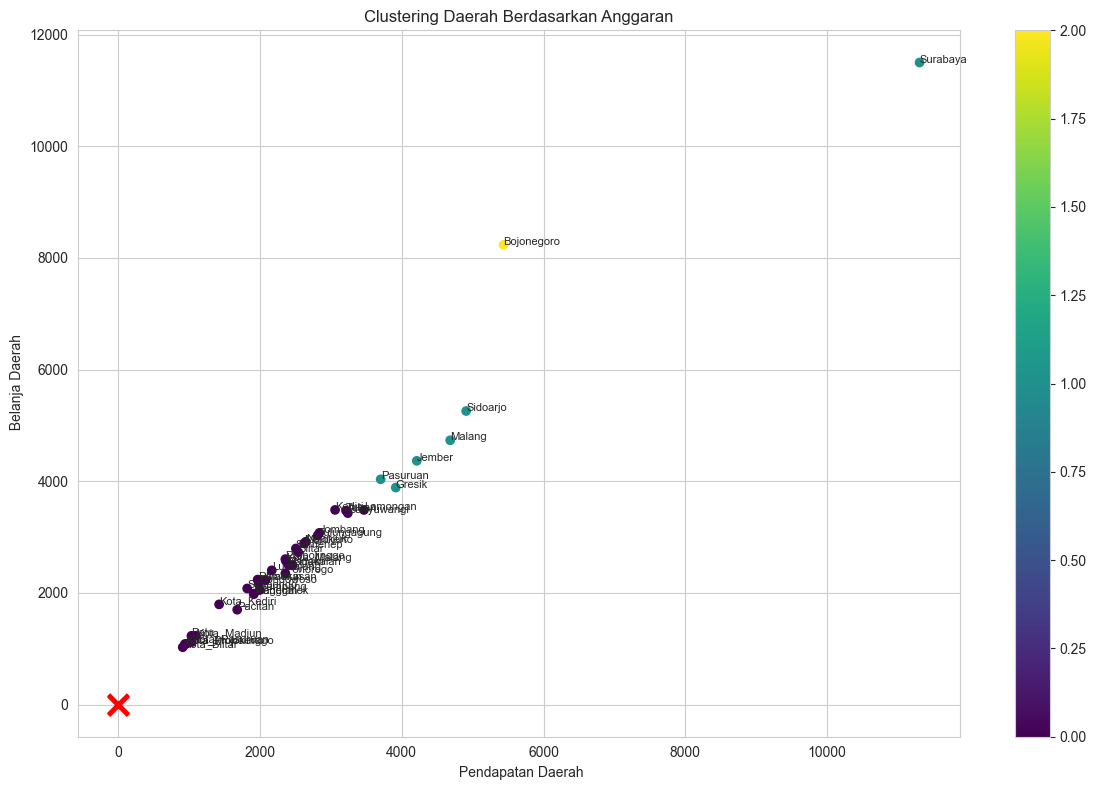


Hasil Clustering:
akun              Cluster   Pendapatan Daerah   Belanja Daerah  \
Daerah                                                           
Bangkalan               0             2402.58          2502.06   
Banyuwangi              0             3239.71          3429.71   
Batu                    0             1034.32          1231.96   
Blitar                  0             2539.66          2729.02   
Bojonegoro              2             5435.62          8235.03   
Bondowoso               0             1984.27          2169.74   
Gresik                  1             3915.51          3887.41   
Jember                  1             4211.89          4366.08   
Jombang                 0             2838.00          3076.00   
Kediri                  0             3059.74          3486.92   
Kota_Blitar             0              911.13          1027.24   
Kota_Kediri             0             1424.24          1795.30   
Kota_Madiun             0             1097.97          12

In [67]:
def visualize_clusters(df, centers):
    plt.figure(figsize=(12, 8))
    
    categories = df.columns[:2]
    
    scatter = plt.scatter(df[categories[0]], df[categories[1]], c=df['Cluster'], cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3)
    
    plt.title('Clustering Daerah Berdasarkan Anggaran')
    plt.xlabel(categories[0])
    plt.ylabel(categories[1])
    plt.colorbar(scatter)
    
    for i, txt in enumerate(df.index):
        plt.annotate(txt, (df[categories[0]].iloc[i], df[categories[1]].iloc[i]), fontsize=8)
    
    plt.tight_layout()
    plt.show()

def perform_clustering(df, n_clusters=3):
    X = df.values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    df['Cluster'] = cluster_labels

    return df, kmeans.cluster_centers_

clustered_df, cluster_centers = perform_clustering(result_df)
visualize_clusters(clustered_df, cluster_centers)

print("\nHasil Clustering:")
print(clustered_df[['Cluster'] + list(result_df.columns)])

for cluster in range(clustered_df['Cluster'].nunique()):
    print(f"\nDaerah dalam Cluster {cluster}:")
    print(clustered_df[clustered_df['Cluster'] == cluster].index.tolist())
    print(f"Karakteristik Cluster {cluster}:")
    print(clustered_df[clustered_df['Cluster'] == cluster].mean())

### D. Kapasitas Fiskal
<p style="text-align: justify;">
Kapasitas Fiskal Daerah adalah kemampuan pemerintah daerah untuk mengumpulkan, mengelola, dan menggunakan sumber daya finansialnya secara efektif. Ini mencakup pendapatan yang diterima oleh pemerintah daerah dari berbagai sumber seperti Pendapatan Asli Daerah (misal: pajak daerah), dana transfer dari pemerintah pusat, serta berbagai pengeluaran untuk membiayai berbagai program dan layanan.

Untuk mengukur tingkat Kapasitas Fiskal Daerah dihitung dengan formula tertentu sehingga dihasilkan Rasio Kapasitas Fiskal Daerah (RKFD). Rasio Kapasitas Fiskal Daerah adalah ukuran yang digunakan untuk mengevaluasi kemampuan pemerintah daerah dalam mengelola kemampuan keuangan mereka. 

Kementerian Keuangan Republik Indonesia menerbitkan Peraturan Menteri Keuangan (PMK) Nomor 84 tahun 2023 tentang Peta Kapasitas Fiskal Daerah. PMK ini mencantumkan tatacara perhitungan Kapasitas Fiskal serta menetapkan Rasio Kapasitas Fiskal Daerah (RKFD) dan Kategori Kapasitas Fiskal Daerah (KKFD). Nilai RKFD dan jenis KKFD untuk Kabupaten/Kota di Jawa Timur telah direkap dalam sebuah excel pada direktori data.

Rumusan Kapasitas Fiskal dalam PMK 84 telah diatur rinci dengan perhitungan pendapatan daerah dan penerimaan pembiayaan daerah tertentu dikurangi dengan pendapatan yang penggunaannya sudah ditentukan, belanja tertentu, dan pengeluaran pembiayaan daerah tertentu. Oleh karena data APBD dari [Portal SIKD Kementrian Keuangan](https://djpk.kemenkeu.go.id/portal/data/apbd?periode=9&tahun=2023&provinsi=13&pemda=38) tidak meliputi level rekening hingga objek, nilai Kapasitas Fiskal dapat kita estimasikan dari rincian data RKFD, KKFD dan Belanja Pegawai. 
</p>

In [68]:
xl = r'.\data\kapasitasFiskal.xlsx'
df = pd.read_excel(xl)

kategori_urut = ['Sangat Rendah', 'Rendah', 'Sedang', 'Tinggi', 'Sangat Tinggi']
df['KFD'] = pd.Categorical(df['KFD'], categories=kategori_urut, ordered=True)
df_sorted = df.sort_values(by='RKFD', ascending=False)

print("Daerah berurutan sesuai nilai RKFD terbesar:")
print(df_sorted[['Daerah', 'RKFD', 'KFD']].to_string(index=False))

Daerah berurutan sesuai nilai RKFD terbesar:
          Daerah  RKFD           KFD
      Bojonegoro 3.532 Sangat Tinggi
        Surabaya 3.078 Sangat Tinggi
      Banyuwangi 2.941 Sangat Tinggi
          Gresik 2.293 Sangat Tinggi
  Kota_Mojokerto 2.214 Sangat Tinggi
     Kota_Blitar 2.164 Sangat Tinggi
        Sidoarjo 1.798 Sangat Tinggi
        Lamongan 1.757 Sangat Tinggi
   Kota_Pasuruan 1.703        Tinggi
     Kota_Malang 1.677        Tinggi
     Kota_Kediri 1.641        Tinggi
          Kediri 1.610        Tinggi
          Malang 1.578        Tinggi
     Kota_Madiun 1.576        Tinggi
            Batu 1.546        Tinggi
        Pasuruan 1.533        Tinggi
          Jember 1.533        Tinggi
        Lumajang 1.496        Tinggi
           Tuban 1.413        Sedang
          Blitar 1.386        Sedang
          Madiun 1.378        Sedang
        Sidoarjo 1.323        Sedang
       Mojokerto 1.322        Sedang
       Pamekasan 1.295        Sedang
         Jombang 1.291        

In [83]:
kategori_anggaran = ["Belanja Pegawai"]
tahun_anggaran = 2023
result_df = process_budget_data(ROOT_DIR, kategori_anggaran)
result_df = result_df.drop_duplicates()

result_df.columns = result_df.columns.str.strip()

# Reset index to make 'Daerah' a column
result_df_reset = result_df.reset_index()

df_merged = pd.merge(df_sorted, result_df_reset[['Daerah', 'Belanja Pegawai']], on='Daerah', how='left')

print("Daerah berurutan sesuai nilai RKFD terbesar dengan Belanja Pegawai:")
print(df_merged[['Daerah', 'RKFD', 'KFD', 'Belanja Pegawai']].to_string(index=False))

Daerah berurutan sesuai nilai RKFD terbesar dengan Belanja Pegawai:
          Daerah  RKFD           KFD  Belanja Pegawai
      Bojonegoro 3.532 Sangat Tinggi          1573.47
        Surabaya 3.078 Sangat Tinggi          2799.74
      Banyuwangi 2.941 Sangat Tinggi          1067.01
          Gresik 2.293 Sangat Tinggi          1081.35
  Kota_Mojokerto 2.214 Sangat Tinggi           346.74
     Kota_Blitar 2.164 Sangat Tinggi           330.57
        Sidoarjo 1.798 Sangat Tinggi          1652.30
        Lamongan 1.757 Sangat Tinggi           949.14
   Kota_Pasuruan 1.703        Tinggi           416.74
     Kota_Malang 1.677        Tinggi          1056.43
     Kota_Kediri 1.641        Tinggi           670.15
          Kediri 1.610        Tinggi          1128.99
          Malang 1.578        Tinggi          1695.04
     Kota_Madiun 1.576        Tinggi           490.37
            Batu 1.546        Tinggi           399.07
        Pasuruan 1.533        Tinggi          1344.05
          Jemb

In [70]:
# Calculate the KF column as the product of RKFD and Belanja Pegawai
df_merged['KF'] = df_merged['RKFD'] * df_merged['Belanja Pegawai']

# Sort the DataFrame by KF in descending order
df_merged_sorted = df_merged.sort_values(by='KF', ascending=False)

# Print the updated DataFrame with the new KF column, sorted by KF
print("Daerah berurutan sesuai nilai KF terbesar dengan Belanja Pegawai dan KF:")
print(df_merged_sorted[['Daerah', 'RKFD', 'KFD', 'Belanja Pegawai', 'KF']].to_string(index=False))

Daerah berurutan sesuai nilai KF terbesar dengan Belanja Pegawai dan KF:
          Daerah  RKFD           KFD  Belanja Pegawai         KF
        Surabaya 3.078 Sangat Tinggi          2799.74 8617.59972
      Bojonegoro 3.532 Sangat Tinggi          1573.47 5557.49604
      Banyuwangi 2.941 Sangat Tinggi          1067.01 3138.07641
        Sidoarjo 1.798 Sangat Tinggi          1652.30 2970.83540
          Malang 1.578        Tinggi          1695.04 2674.77312
          Gresik 2.293 Sangat Tinggi          1081.35 2479.53555
          Jember 1.533        Tinggi          1480.92 2270.25036
        Sidoarjo 1.323        Sedang          1652.30 2185.99290
        Pasuruan 1.533        Tinggi          1344.05 2060.42865
          Kediri 1.610        Tinggi          1128.99 1817.67390
     Kota_Malang 1.677        Tinggi          1056.43 1771.63311
           Tuban 1.413        Sedang          1200.12 1695.76956
        Lamongan 1.757 Sangat Tinggi           949.14 1667.63898
         Jombang 

### Visualisasi Kapasitas Fiskal Daerah

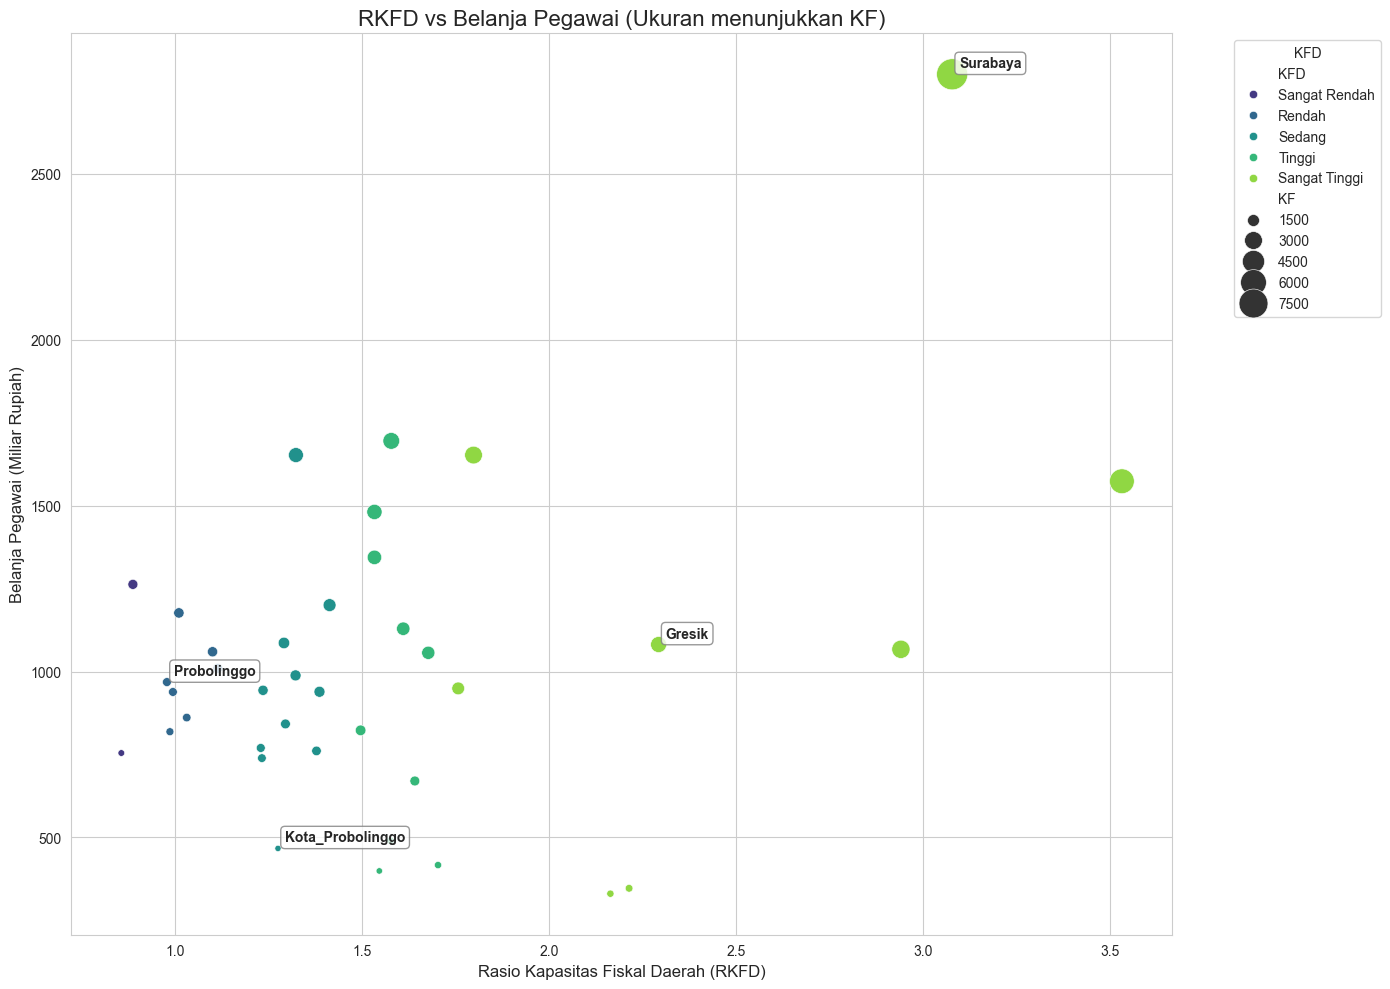

In [86]:
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_merged_sorted, x='RKFD', y='Belanja Pegawai', 
                hue='KFD', size='KF', sizes=(20, 500), 
                palette='viridis')

plt.title('RKFD vs Belanja Pegawai (Ukuran menunjukkan KF)', fontsize=16)
plt.xlabel('Rasio Kapasitas Fiskal Daerah (RKFD)', fontsize=12)
plt.ylabel('Belanja Pegawai (Miliar Rupiah)', fontsize=12)

daerah_anotasi = ['Surabaya', 'Gresik', 'Probolinggo', 'Kota_Probolinggo']
for daerah in daerah_anotasi:
    row = df_merged_sorted[df_merged_sorted['Daerah'] == daerah].iloc[0]
    plt.annotate(daerah, (row['RKFD'], row['Belanja Pegawai']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.legend(title='KFD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Visualisasi ini menunjukkan hubungan antara Rasio Kapasitas Fiskal Daerah (RKFD) dan Belanja Pegawai. Setiap titik mewakili satu daerah, dengan warna menunjukkan Kategori Kapasitas Fiskal Daerah (KFD) dan ukuran titik menunjukkan nilai Kapasitas Fiskal (KF).<br>
Dari plot ini, kita dapat melihat apakah ada korelasi antara RKFD dan Belanja Pegawai. Kita juga dapat mengidentifikasi daerah-daerah dengan KF tinggi (titik besar) dan bagaimana posisinya relatif terhadap daerah lain. Daerah-daerah dengan kombinasi RKFD tinggi dan Belanja Pegawai tinggi cenderung memiliki KF yang lebih besar (ditunjukkan oleh ukuran titik yang lebih besar).

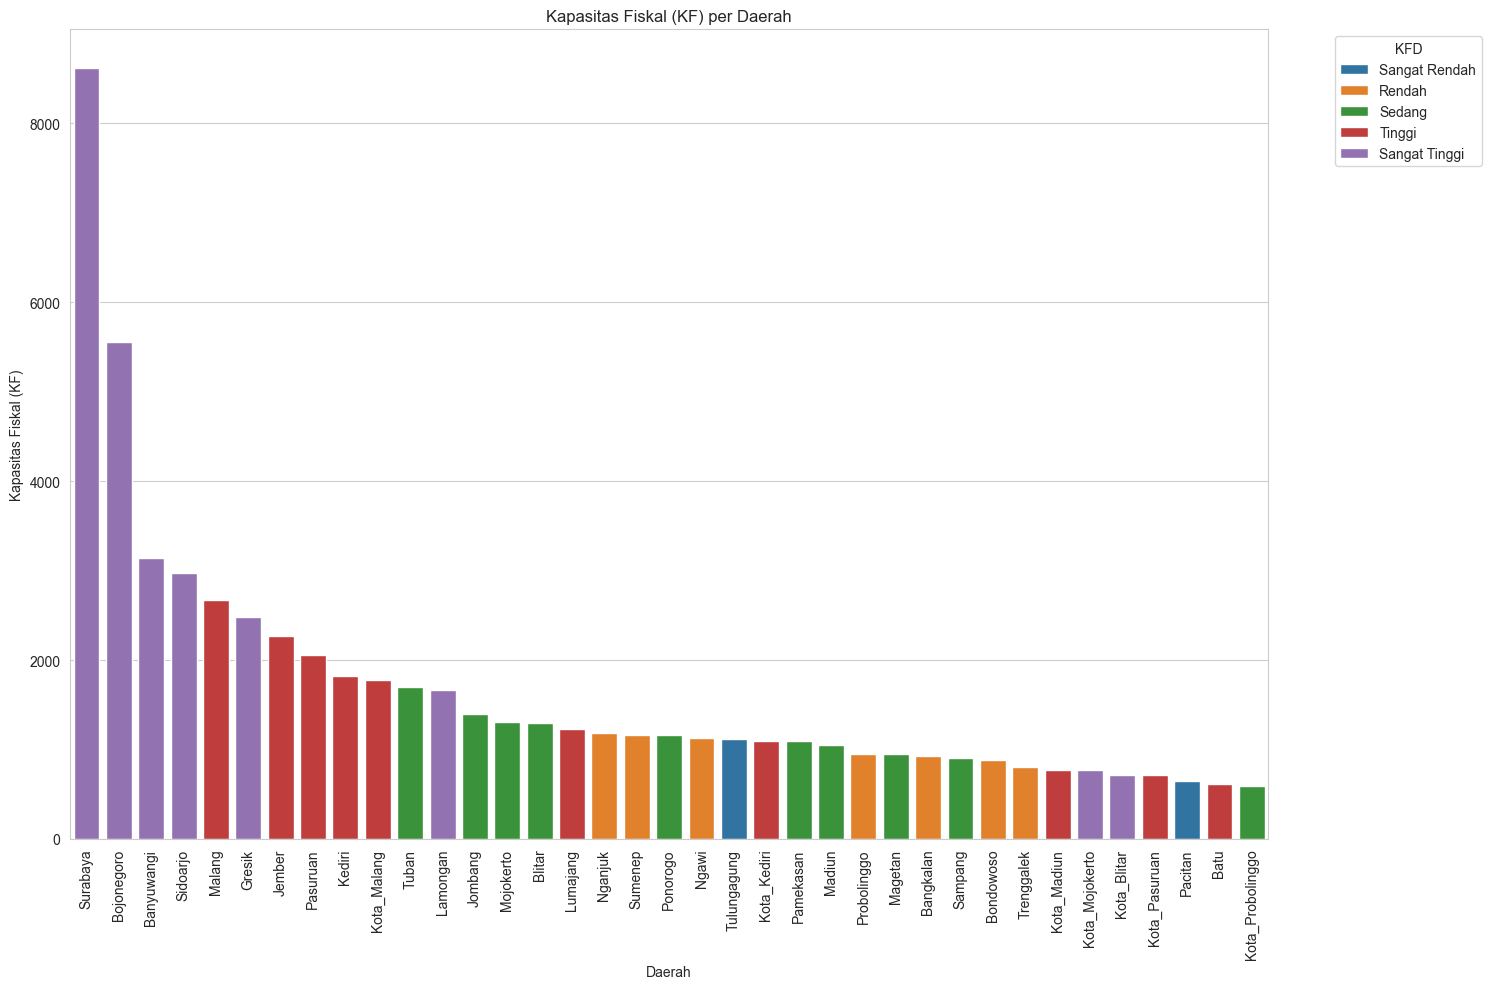

In [74]:
# 2. Bar plot KF per Daerah
plt.figure(figsize=(15, 10))
sns.barplot(data=df_merged_sorted, x='Daerah', y='KF', hue='KFD', dodge=False)
plt.title('Kapasitas Fiskal (KF) per Daerah')
plt.xlabel('Daerah')
plt.ylabel('Kapasitas Fiskal (KF)')
plt.xticks(rotation=90)
plt.legend(title='KFD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Grafik batang ini menampilkan Kapasitas Fiskal Daerah (KFD) untuk setiap daerah, diurutkan dari yang tertinggi ke terendah. Warna batang menunjukkan Kategori KFD.<br>
Dari plot ini, kita dapat dengan mudah membandingkan KFD antar daerah. Kita juga dapat melihat distribusi KFD di antara daerah-daerah dengan KF tinggi dan rendah. Plot ini membantu mengidentifikasi daerah-daerah yang mungkin memerlukan perhatian khusus dalam hal kapasitas fiskal.

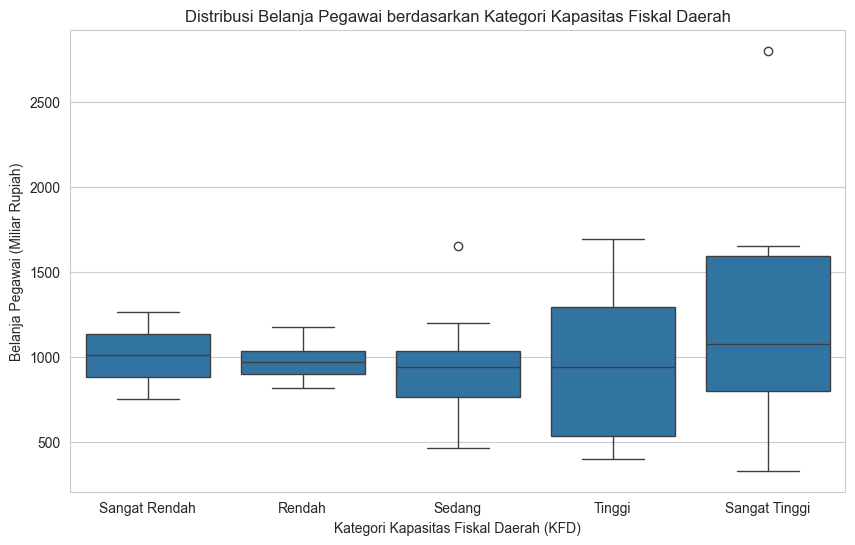

In [78]:
# 3. Box plot Belanja Pegawai berdasarkan KFD
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged_sorted, x='KFD', y='Belanja Pegawai')
plt.title('Distribusi Belanja Pegawai berdasarkan Kategori Kapasitas Fiskal Daerah')
plt.xlabel('Kategori Kapasitas Fiskal Daerah (KFD)')
plt.ylabel('Belanja Pegawai (Miliar Rupiah)')
plt.show()

Box plot ini menggambarkan distribusi Belanja Pegawai untuk setiap Kategori Kapasitas Fiskal Daerah (KFD), membantu kita melihat perbedaan dan variasi dalam belanja pegawai antar kategori. Dari plot ini, kita dapat melihat median, kuartil, dan outlier Belanja Pegawai untuk setiap KFD.<br>
Kita dapat membandingkan variasi Belanja Pegawai antar kategori KFD. Plot ini membantu mengidentifikasi apakah ada perbedaan signifikan dalam Belanja Pegawai antara daerah dengan KFD berbeda. Outlier dalam plot ini mungkin menunjukkan daerah-daerah yang memerlukan analisis lebih lanjut.

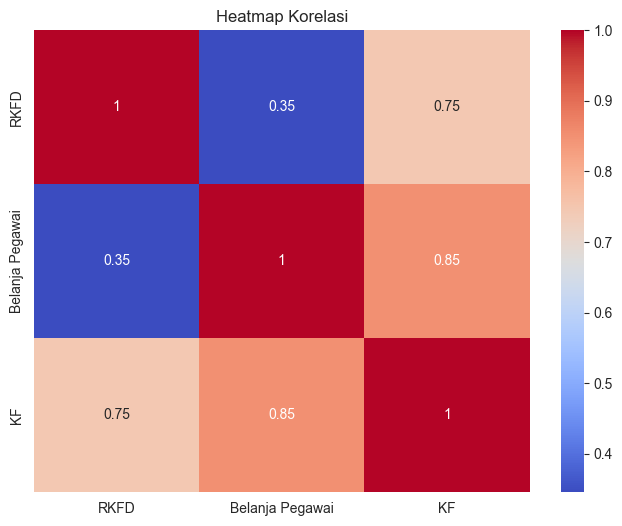

In [77]:
# 4. Heatmap Korelasi
correlation = df_merged_sorted[['RKFD', 'Belanja Pegawai', 'KF']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi')
plt.show()

Heatmap ini menunjukkan korelasi antara RKFD, Belanja Pegawai, dan KF, membantu kita memahami hubungan antar variabel ini. Poin lain dari heatmap ini adalah;
1. Warna merah menunjukkan korelasi positif, sedangkan warna biru menunjukkan korelasi negatif.
2. Angka di setiap sel menunjukkan nilai korelasi, dari -1 (korelasi negatif sempurna) hingga 1 (korelasi positif sempurna).
3. Dari heatmap ini, kita dapat melihat seberapa kuat hubungan antara variabel-variabel tersebut.
4. Korelasi yang kuat antara variabel tertentu mungkin menunjukkan area yang memerlukan perhatian khusus dalam 

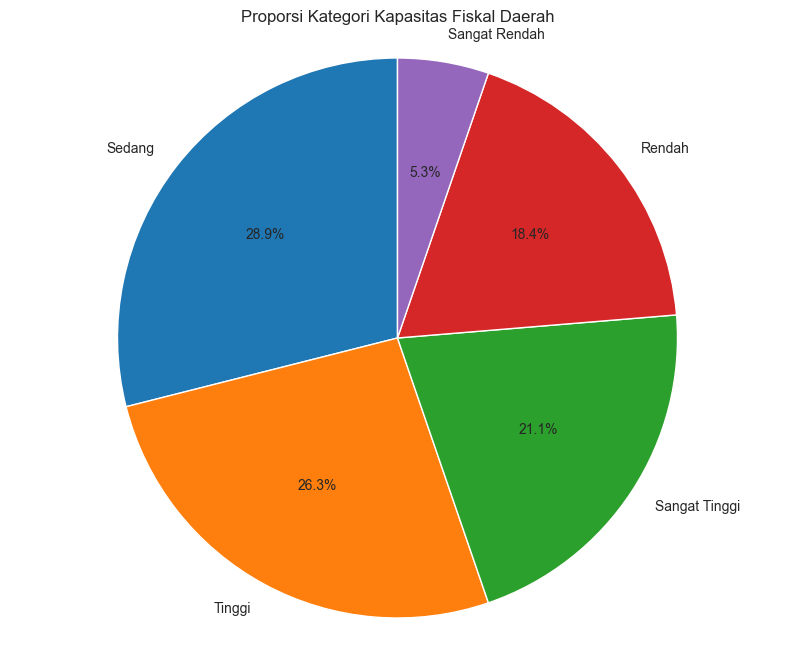

In [76]:
# 5. Pie chart Proporsi KFD
kfd_counts = df_merged_sorted['KFD'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(kfd_counts, labels=kfd_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Kategori Kapasitas Fiskal Daerah')
plt.axis('equal')
plt.show()

Diagram pie ini menampilkan proporsi daerah dalam setiap Kategori Kapasitas Fiskal Daerah (KFD), memberikan gambaran umum tentang distribusi kapasitas fiskal di seluruh daerah.

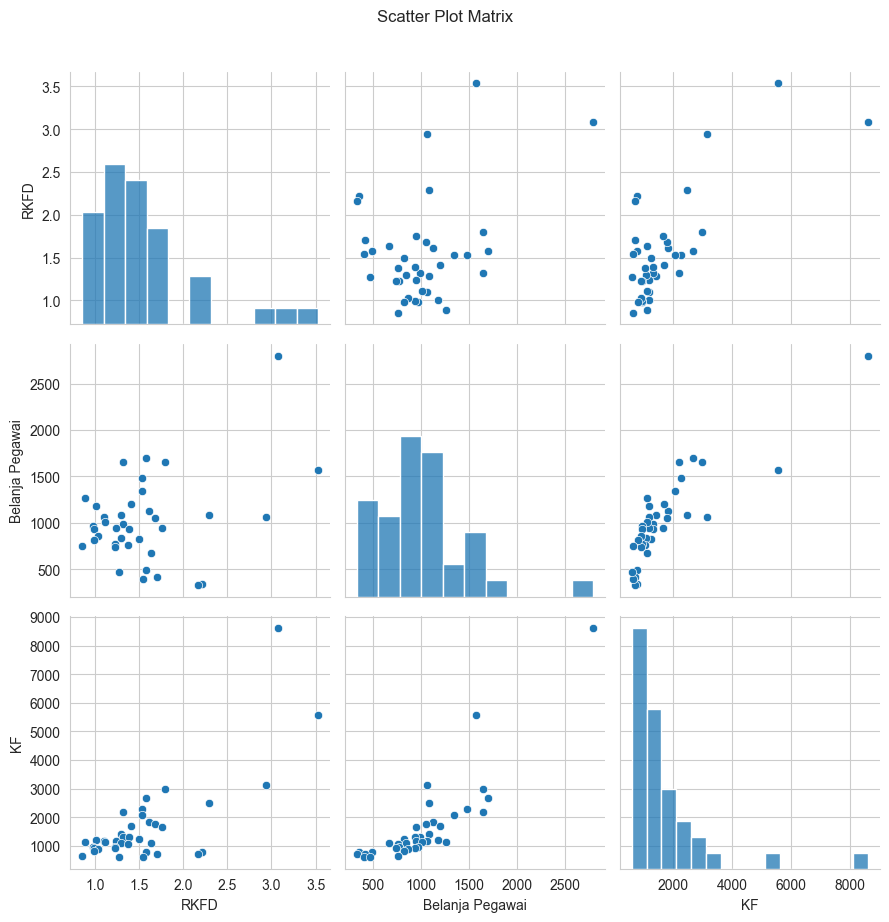

In [79]:
# 6. Scatter plot matrix
sns.pairplot(df_merged_sorted[['RKFD', 'Belanja Pegawai', 'KF']], height=3)
plt.suptitle('Scatter Plot Matrix', y=1.02)
plt.tight_layout()
plt.show()

Interpretasi dari grafik ini adalah sebagai berikut;
1. Scatter plot matrix ini menunjukkan hubungan antara RKFD, Belanja Pegawai, dan KF dalam bentuk matriks.
2. Setiap sel menunjukkan hubungan antara dua variabel.
3. Diagonal matriks menunjukkan distribusi masing-masing variabel.
4. Dari plot ini, kita dapat melihat pola dan korelasi antar variabel secara visual.
5. Pola linear atau non-linear yang terlihat dapat memberikan wawasan tentang hubungan antar variabel.
6. Outlier atau cluster yang terlihat dalam plot ini mungkin menunjukkan daerah-daerah yang memerlukan analisis lebih lanjut.